# «ТелеДом»  борьба с оттоком клиентов

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

## Знакомство с данными

Установии/обновим библиотеки

In [1]:
!pip install phik
!pip install scikit-learn==1.1.3

Подключение библиотек

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import numpy as np

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (roc_auc_score,
                             accuracy_score,
                             roc_curve,
                             confusion_matrix)
from sklearn.model_selection import (GridSearchCV, train_test_split)
from catboost import CatBoostClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder
)
from sklearn.pipeline import make_pipeline
from phik.report import plot_correlation_matrix
from phik import report


RANDOM_STATE=27112023

Загрузим данные

In [3]:
df_contract = pd.read_csv('contract_new.csv')
df_personal = pd.read_csv('personal_new.csv')
df_internet = pd.read_csv('internet_new.csv')
df_phone = pd.read_csv('phone_new.csv')

Выведем первые 5 строк каждого датафрейма и посмотрим какие данные они хранят

In [4]:
df_contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


* **customerID** — идентификатор абонента 
* **BeginDate** — дата начала действия договора 
* **EndDate** — дата окончания действия договора 
* **Type** — тип оплаты: раз в год-два или ежемесячно
* **PaperlessBilling** — электронный расчётный лист 
* **PaymentMethod** — тип платежа 
* **MonthlyCharges** — расходы за месяц 
* **TotalCharges** — общие расходы абонента 

In [5]:
df_personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


* **customerID** — идентификатор пользователя;
* **gender** — пол;
* **SeniorCitizen** — является ли абонент пенсионером;
* **Partner** — есть ли у абонента супруг или супруга;
* **Dependents** — есть ли у абонента дети.

In [6]:
df_internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


* **customerID** — идентификатор пользователя;
* **InternetService** — тип подключения;
* **OnlineSecurity** — блокировка опасных сайтов;
* **OnlineBackup** — облачное хранилище файлов для резервного копирования данных;
* **DeviceProtection** — антивирус;
* **TechSupport** — выделенная линия технической поддержки;
* **StreamingTV** — стриминговое телевидение;
* **StreamingMovies** — каталог фильмов.

In [7]:
df_phone.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


* **customerID** — идентификатор пользователя;
* **MultipleLines** — подключение телефона к нескольким линиям одновременно.

Посмотрим информацию о каждом датафрейме, для этого напишем мини-функцию которая будет выводить случайные 2 строчки, информацию по типам и количеству наблюдений и общей статистике по датафрейму, которого приняла на вход эта функция.

In [8]:
def info(df):
    display(df.sample(2, random_state=RANDOM_STATE))
    df.info()
    display(df.describe(include='all'))
    print(f'Количество явных дубликатов: {df.duplicated().sum()}')
    print(f'Количество дубликатов по столбцу customerID: {df.duplicated(subset="customerID").sum()}')

общая информация по датафрейму **df_contract**

In [9]:
info(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1434,1571-SAVHK,2018-10-01,No,Month-to-month,Yes,Mailed check,99.95,1631.18
1490,8016-ZMGMO,2014-08-01,No,One year,Yes,Bank transfer (automatic),70.85,4769.62


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


Количество явных дубликатов: 0
Количество дубликатов по столбцу customerID: 0


* Пропусков нет
* Дубликатов нет
* Типы данных можно изменить в столбцах
    * **BeginDate** - object  -> datetime
    * **TotalCharges** - object -> float64
* Нужно привести названия столбцов к стилю snake_case

In [10]:
info(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
1434,1571-SAVHK,Male,0,No,No
1490,8016-ZMGMO,Female,1,Yes,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


Количество явных дубликатов: 0
Количество дубликатов по столбцу customerID: 0


* Пропусков нет
* Дубликатов нет
* типы данных трогать не нужно
* Нужно привести названия столбцов к стилю snake_case

In [11]:
info(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
2927,9822-WMWVG,Fiber optic,Yes,Yes,Yes,Yes,Yes,No
2789,4317-VTEOA,DSL,No,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Количество явных дубликатов: 0
Количество дубликатов по столбцу customerID: 0


* Пропусков нет
* Дубликатов нет
* Типы данных трогать не нужно
* Нужно привести названия столбцов к стилю snake_case

In [12]:
info(df_phone)

,customerID,MultipleLines
4705,2080-CAZNM,Yes
1068,3992-YWPKO,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Количество явных дубликатов: 0
Количество дубликатов по столбцу customerID: 0


* Пропусков нет
* Дубликатов нет
* Типы данных трогать не нужно
* Нужно привести названия столбцов к стилю snake_case

### Выводы по знакомству с данными:
* Пропусков в данных нет
* Дубликатов в данных нет
* Типы данных надо изменить в таблице df_contract
    * **BeginDate** - object  -> datetime
    * **TotalCharges** - object -> float64
* Все названия столбцов надо привести к стилю snake_case

## Предобработка

### Изменим названия столбцов

Приведем названия столбцов в **df_contract** к стилю *snake_case*

In [13]:
df_contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges']
df_contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

Названия столбцов изменились применим ту же самую операцию на другие датафреймы

**df_personal**

In [14]:
df_personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']
df_personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

**df_internet**

In [15]:
df_internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
df_internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

**df_phone**

In [16]:
df_phone.columns = ['customer_id', 'multiple_lines']
df_phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

Как мы видим названия столбцов были изменены, можно приступать к изменению типов данных

### Изменение типов данных

Посмотрим на типы данных в **df_contract**

In [17]:
df_contract.dtypes

customer_id           object
begin_date            object
end_date              object
type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges         object
dtype: object

Посмотрим есть ли пропуски в cтолбцe **total_charges**

In [18]:
df_contract[df_contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Как мы видим у нас есть пропуски в столбце **total_chargees**, Скорее всего так получилось из-за того что пользователи только заключили договор, напишем в **total_chargees**  0

In [19]:
df_contract['total_charges'] = df_contract[['total_charges']].replace(" ", 0).astype('float64')

Изменим тип в столбце **begin_date** на *datetime*, для начала посмотрим все уникальные значения в этом столбце

In [20]:
df_contract['begin_date'].unique()

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

Можем заметить что все уникальные даты начинаются с первого дня месяца

In [21]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')

Переведем даты в тип datetime

In [22]:
df_contract.dtypes

customer_id                  object
begin_date           datetime64[ns]
end_date                     object
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
dtype: object

### Объеденение данных

Создадим датафрейм **df** в котором будут данные из датафреймов: **df_contract**, **df_internet**, **df_personal**, **df_phone**

In [23]:
df = df_contract.copy()
df = (df.merge(df_internet, on ='customer_id', how = 'outer')
        .merge(df_personal, on ='customer_id', how = 'outer')
        .merge(df_phone, on ='customer_id', how = 'outer'))


Выведем первые 5 строк нового датафрейма **df**

In [24]:
df.head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


Выведем общую информацию о новом датафрейме

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   internet_service   5517 non-null   object        
 9   online_security    5517 non-null   object        
 10  online_backup      5517 non-null   object        
 11  device_protection  5517 non-null   object        
 12  tech_support       5517 non-null   object        
 13  streaming_tv       5517 non-null   object        
 14  streamin

Как мы видим у нас появились пропущенные значения, скорее всего они появились из-за того что не все таблицы содержали данные о том или ином пользователе. Допустим если человек не подключил услуги интернета (тойсь его нет в таблице *df_internet*), то в новой таблице у него будут пропуски в столбцах которые были в **df_internet**

Посмотрим на количество пропусков в данных

In [26]:
df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines        682
dtype: int64

Посмотрим какая разница между количеством записей в таблице **df_contract** и **df_internet, чтобы подтвердить наше предположение

In [27]:
df_contract.shape[0] - df_internet.shape[0]

1526

Проверим разницу между **df_contract** и **df_phone**

In [28]:
df_contract.shape[0] - df_phone.shape[0]

682

Как мы видим наше предположение подтвердилось

Так как из-за соединения данных у нас появились 1526 пропусков, с людьми которые не используют интернет, заполним все пропуски строкой *NCI* - *not connected internet*

In [29]:
df[df_internet.columns] = df[df_internet.columns].fillna('NCI')

Проверим количество пропусков

In [30]:
df.isna().sum()

customer_id            0
begin_date             0
end_date               0
type                   0
paperless_billing      0
payment_method         0
monthly_charges        0
total_charges          0
internet_service       0
online_security        0
online_backup          0
device_protection      0
tech_support           0
streaming_tv           0
streaming_movies       0
gender                 0
senior_citizen         0
partner                0
dependents             0
multiple_lines       682
dtype: int64

Отлично мы избавились от всех пропусков которые возникли в результате присоединения таблицы **df_internet**, сделаем то же самое и для столбцов таблицы **df_phone**, только изменим строку которой мы заменяем пропуски на NCP

In [31]:
df[df_phone.columns] = df[df_phone.columns].fillna('NCP')

Проверим количество пропусков

In [32]:
df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
dtype: int64

Пропусков нет можно двигаться дальше.

### Целевая переменная


Нам нужно создать целевую переменную, так как нас интересует предсказание того будет ли договор расторгнут или нет, посмотрим на уникальные значения в столбце **end_date**, в котором показана дата окончания действия договора

In [33]:
df.end_date.unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

Как мы можем заметить в столбце **end_date** есть даты и значение *No* 
* Если значение в **end_date** равно *No*, то в столбце **target** будет 0
* Если значение в **end_date** не равно *No*, то в столбце **target** будет 1

In [34]:
df.loc[df['end_date'] == 'No','target'] = 0
df.loc[df['end_date'] != 'No','target'] = 1
df['target'] = df['target'].astype('int8')
df[['end_date','target']].sample(10,random_state=RANDOM_STATE)

,end_date,target
1434,No,0
1490,No,0
2231,No,0
3614,No,0
5287,No,0
202,2016-07-01,1
1572,No,0
6629,No,0
552,No,0
5855,No,0


In [35]:
# код ментора для объяснения
(df['end_date'] != 'No').astype(int)

0       0
1       0
2       0
3       0
4       0
       ..
7038    0
7039    0
7040    0
7041    0
7042    0
Name: end_date, Length: 7043, dtype: int32

Как мы видим алгоритм работает правильно, посмотрим на баланс классов в целевой переменной

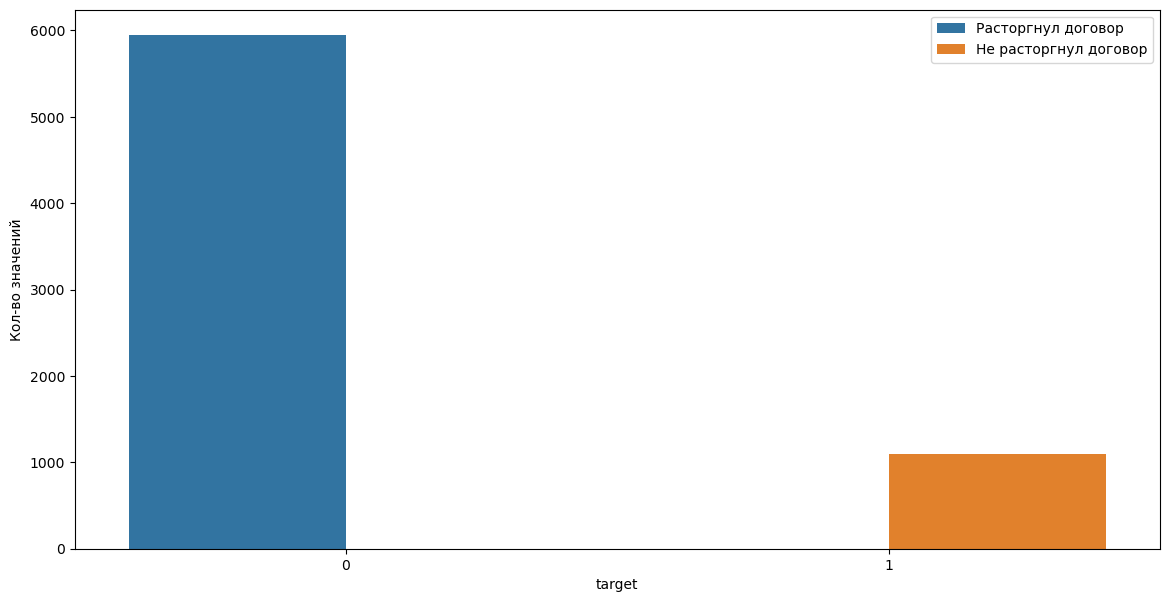

In [36]:
plt.figure(figsize = (14,7))
sns.countplot(data=df, x='target', hue="target").set(ylabel='Кол-во значений');
plt.legend(['Расторгнул договор', 'Не расторгнул договор']);

Соотношение не ушедших к ушедшим пользователям  1:5

### Создание новых признаков

#### end_begin_diff

Создадим новый столбец который будет показывать какое количество дней прошло между днем заключения договора и его расторжением.
Если договор не был расторгнут, то будем считать что в столбце **end_date** лежит актуальная дата об данных нам договорах - 1 февраля 2020

In [37]:
df['end_date'] = df['end_date'].replace('No', '2020-02-01')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

Создадим столбец **end_begin_diff** и выведем 5 строк датафрейма

In [38]:
df['end_begin_diff'] = (df['end_date'] - df['begin_date']).astype('timedelta64[D]')
df[['begin_date', 'end_date', 'end_begin_diff']].head(5)

,begin_date,end_date,end_begin_diff
0,2020-01-01,2020-02-01,31.0
1,2017-04-01,2020-02-01,1036.0
2,2019-10-01,2020-02-01,123.0
3,2016-05-01,2020-02-01,1371.0
4,2019-09-01,2020-02-01,153.0


Успешно создали столбец

### Выводы по предобработке
* Привели названия столбцов к стилю snake_case
* Изменили типы данных
* Объединили данные нам датафреймы в один датафрейм **df**
* Определили целевую переменную по столбцу *end_date*
* Создали новый признак *end_begin_diff*, который показывает сколько прошло времени с момента начала использования услуг оператора и до конца/текущего дня

## Исследовательский анализ данных

### Посмотрим на приток и отток пользователей 

Для начала создадим датафрейм в котором будут данные до 2020 года, я не думаю что его стоит учитывать так как идет только 2 месяц этого года и выше мы назначили всем не расторгнутым договорам февраль этого года 

In [39]:
year_df = df.loc[df.end_date.dt.year != 2020].copy()
year_df.loc[:, 'year_end'] = year_df.end_date.dt.year
year_df.loc[:, 'year_begin'] = year_df.begin_date.dt.year

Построим графики

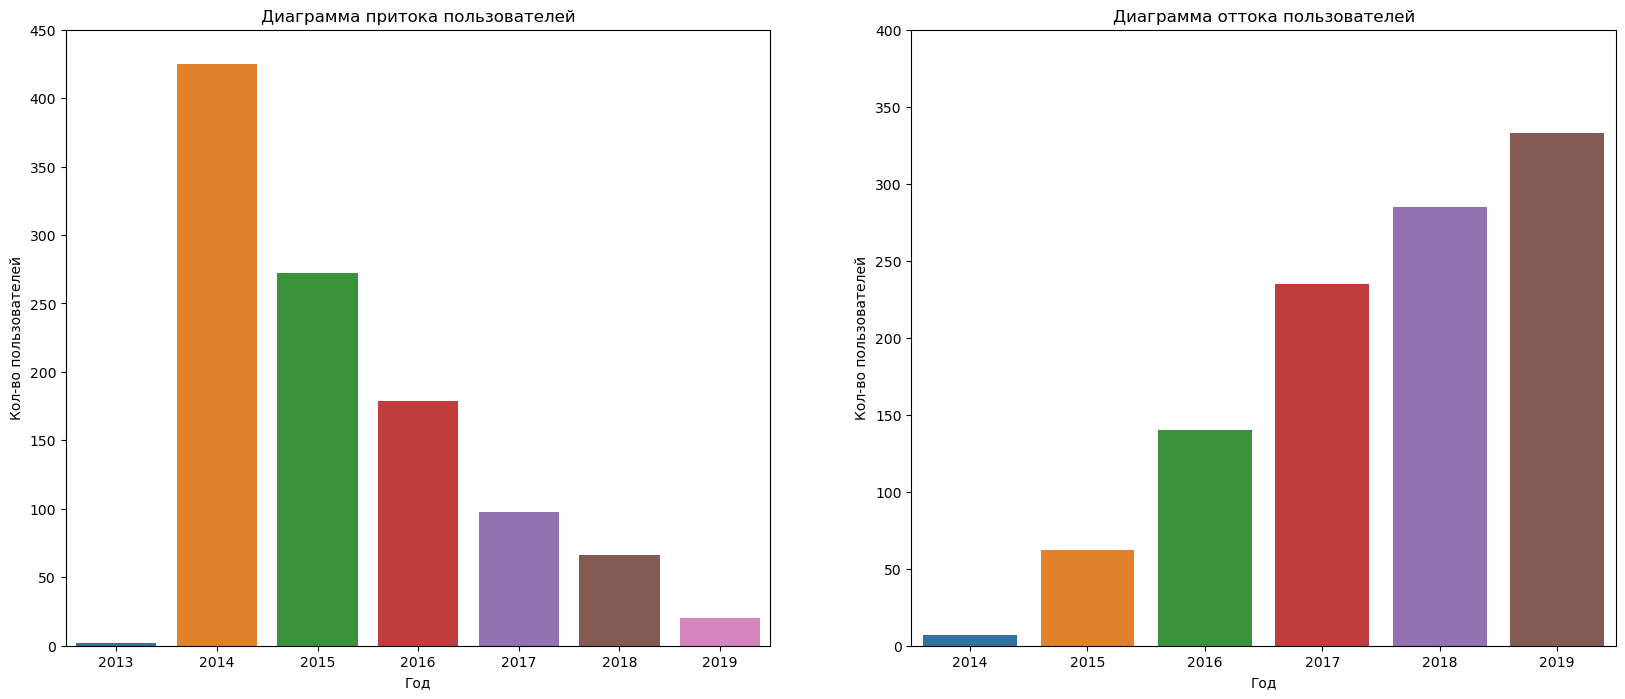

In [40]:
fig, ax = plt.subplots(1,2,figsize=(20,8)) 
sns.countplot(data=year_df, x='year_begin', ax=ax[0]).set(title='Диаграмма притока пользователей',
                                                          ylabel='Кол-во пользователей',
                                                          xlabel='Год',
                                                          yticks=range(0,451,50));
sns.countplot(data=year_df, x='year_end', ax=ax[1]).set(title='Диаграмма оттока пользователей',
                                                        ylabel='Кол-во пользователей',
                                                        xlabel='Год',
                                                        yticks=range(0,401,50));

Графики выглядят не утешительно:
* С каждым годом все меньше людей начинают пользоваться услугами оператора связи
* С каждым годом все больше людей расторгают договоры с оператором

### Дополнительные услуги

Посмотрим зависит ли количество подключенных услуг из таблицы **df_internet** на целевую переменную

Напишем функцию **count_services** которая будет возвращать количество подключенных услуг у пользователя

In [41]:
def count_services(row):
    return row[row == 'Yes'].count()

Применим функцию к нашему датафрейму и сохраним в столбец **count_services**

In [42]:
df['count_services'] = df[['online_security', 'online_backup',
                           'device_protection', 'tech_support',
                           'streaming_tv', 'streaming_movies']].apply(count_services, axis=1)


### Корреляция признаков

Перед тем как строить матрицу корреляции из датафрейма нужно убрать признаки непригодные для машинного обучения 
* customer_id - уникальный идентификатор клиента
* begin_date - дата заключения контракта
* end_date - дата окончания контракта

в

In [43]:
df = df.drop(['customer_id','begin_date', 'end_date', 'gender'], axis=1)

Посмотрим на матрицу корреляции *phik*

In [44]:
phik_overview = df.phik_matrix(interval_cols=['monthly_charges', 'total_charges',
                                              'end_begin_diff'])
phik_overview.round(2);

Посмотрим на нашу матрицу

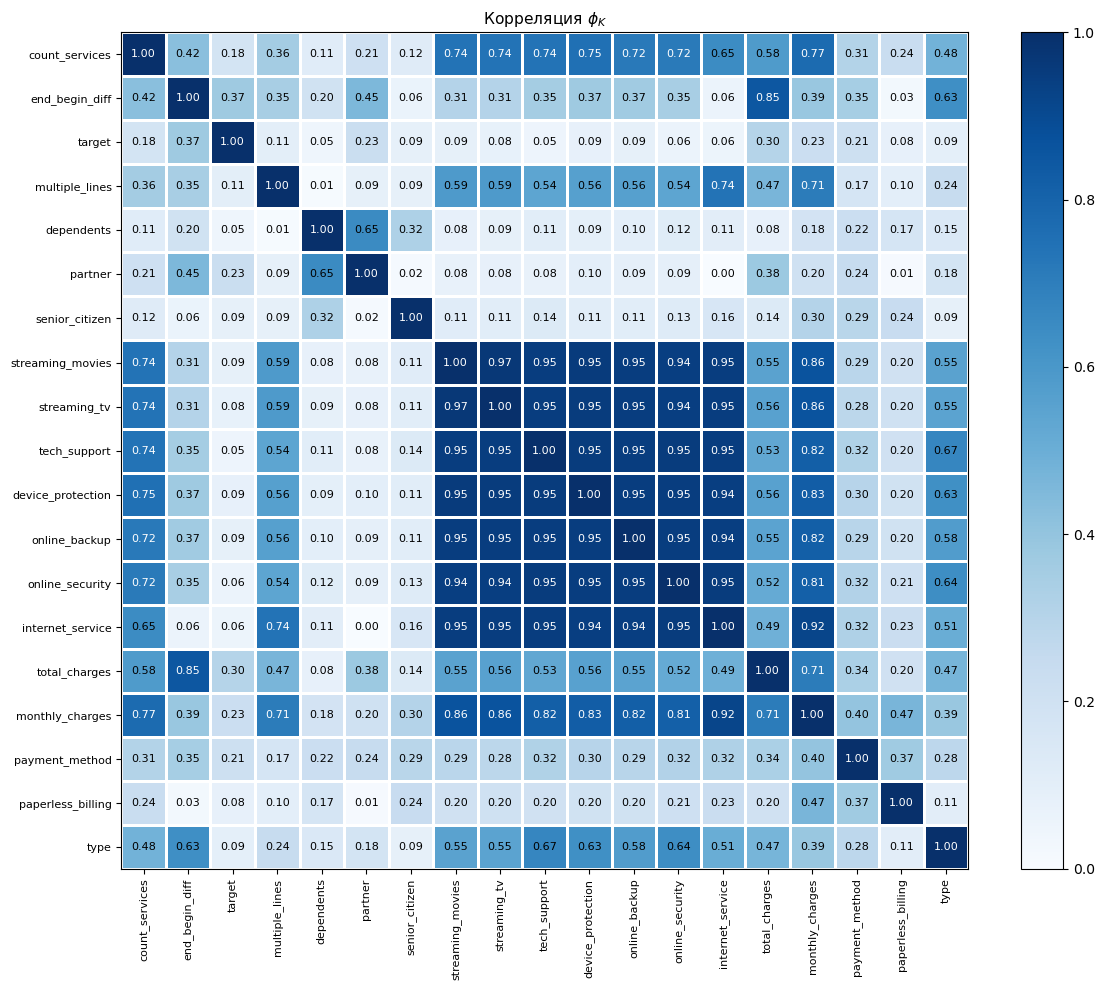

In [45]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=0.8, 
                        figsize=(12, 10))
plt.tight_layout()
plt.show()

Избавимся от мультиколлинеарности и признаков с очень низкой корреляцией с целевой переменной:
* streaming_tv
* streaming_movies
* online_backup
* tech_support
* device_protection
* online_security
* internet_service
* type
* paperless_billing
* dependents

In [46]:
df = df.drop(['streaming_tv', 'streaming_movies', 'online_backup',
             'tech_support', 'device_protection', 'online_security', 'internet_service',
              'dependents', 'paperless_billing', 'type'],
           axis=1)

Посмотрим на матрицу корреляции еще раз

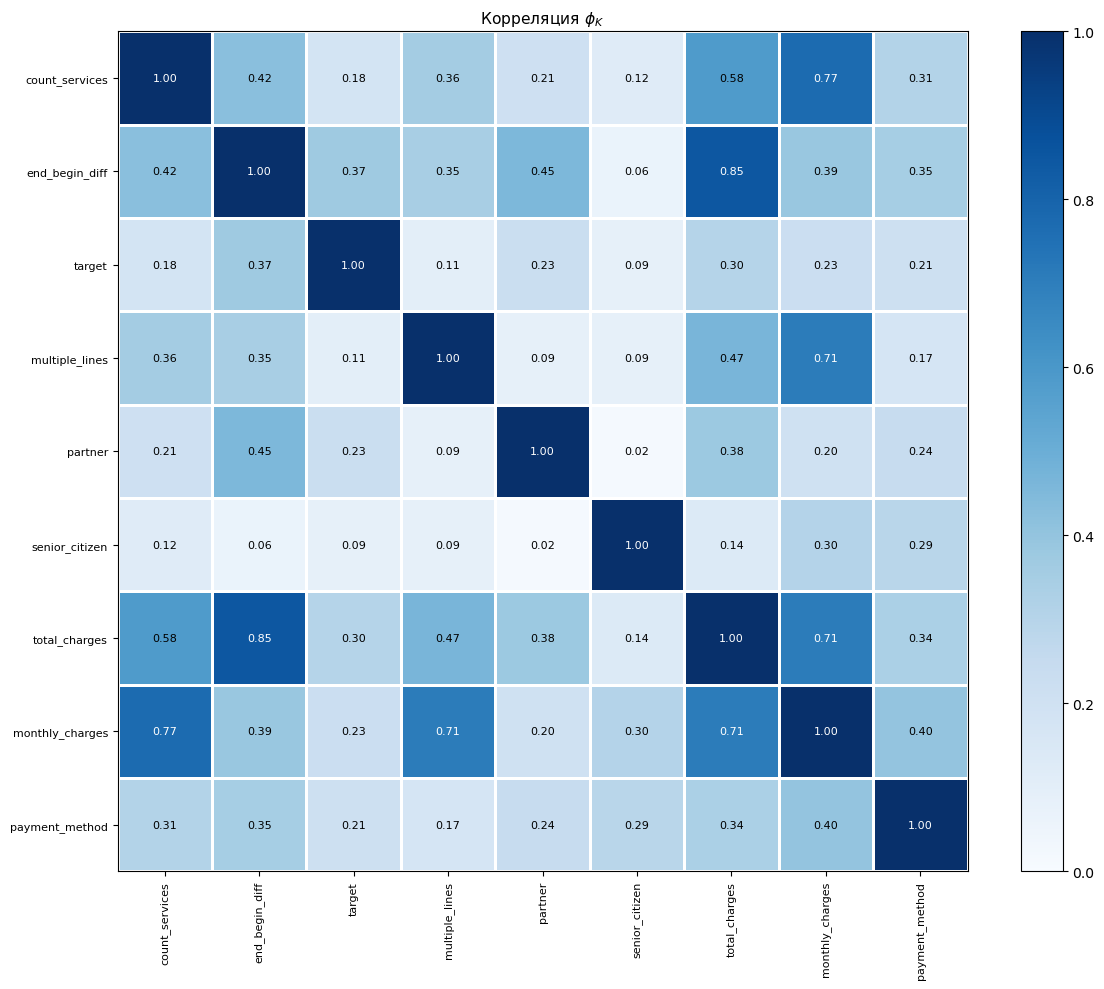

In [47]:
phik_overview = df.phik_matrix(interval_cols=['monthly_charges', 'total_charges',
                                              'end_begin_diff'])
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=0.8, 
                        figsize=(12, 10))
plt.tight_layout()
plt.show()

Посмотри на признаки которые заметно коррелируют с целевой переменной. Для этого напишем функцию, которая будет строить 
* Скрипичную диаграмму
* Гистограмму, если количество уникальных значений меньше 25
* Выводить значение корреляции с целевой переменной

In [48]:
def violent_plot(df, column, target):
    plt.figure(figsize = (12, 10))
    sns.violinplot(
        x = target,
        y = column,
        data = df,
        kind = "violin",
        split = True,
        palette = "coolwarm"
    )
    plt.show()

    if df[column].nunique() <= 25:
        plt.figure(figsize = (12, 10))
        sns.histplot(data=df,
                     x=column,
                     binwidth=1,
                     hue=target)
        plt.show()

    print()
    print('Корреляция Phik:', np.round(phik_overview.loc[column]['target'], 2))
    print('-----------------------------------------------------------------------------------------------')
    print()

Посмотрим на корреляцию **end_begin_diff** и **target**

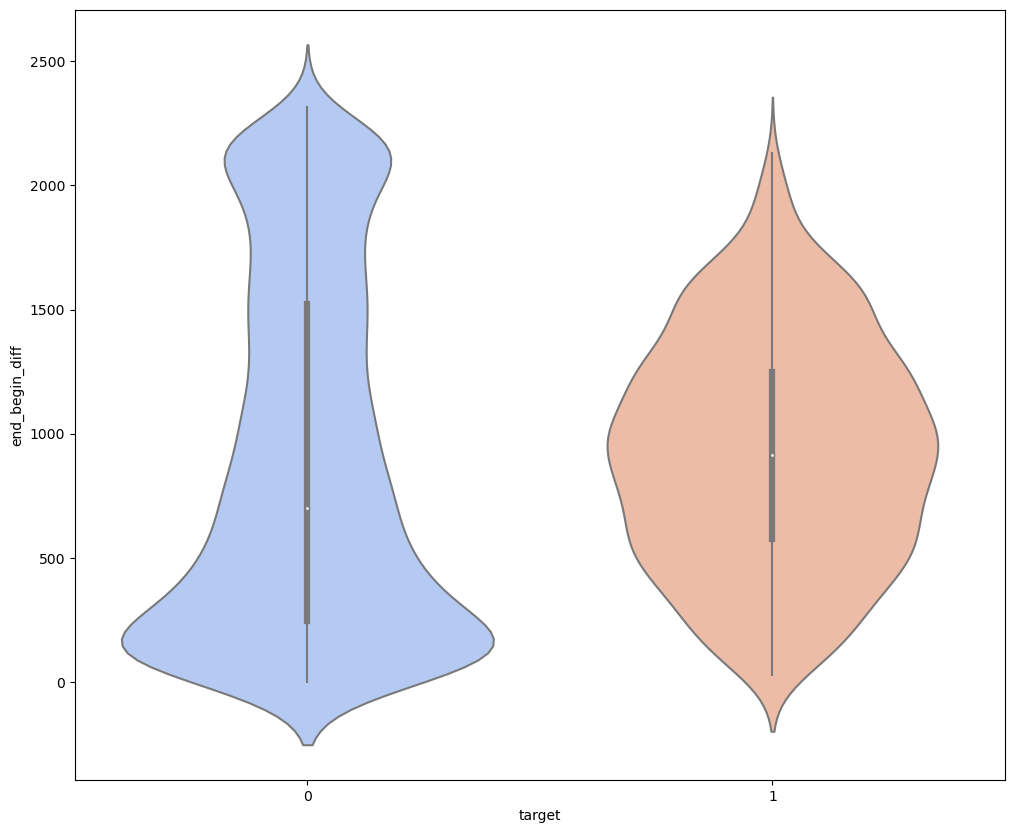


Корреляция Phik: 0.37
-----------------------------------------------------------------------------------------------



In [49]:
violent_plot(df, 'end_begin_diff','target')

Как мы видим те кто уходят чаще всего мало или наоборот долго пользуются услугами оператора связи. В то время как действующие пользователи в среднем пользуются 1000 дней

Посмотрим как влияет наличие супруга/супруги у  на целевую переменную

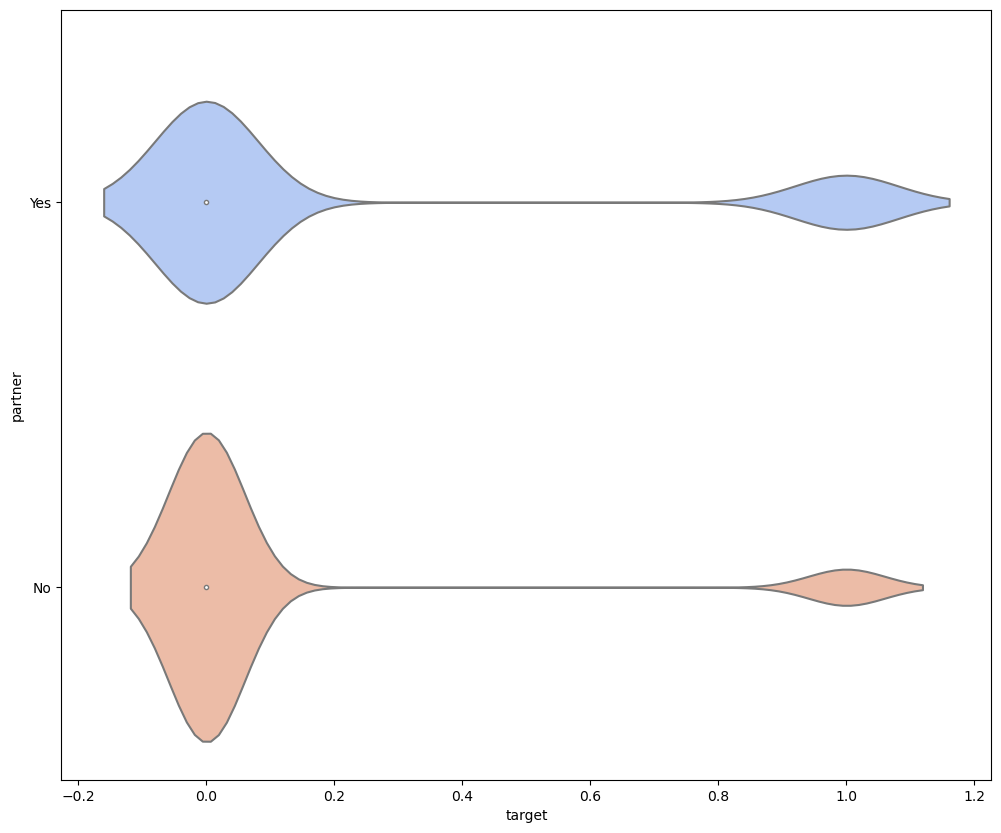

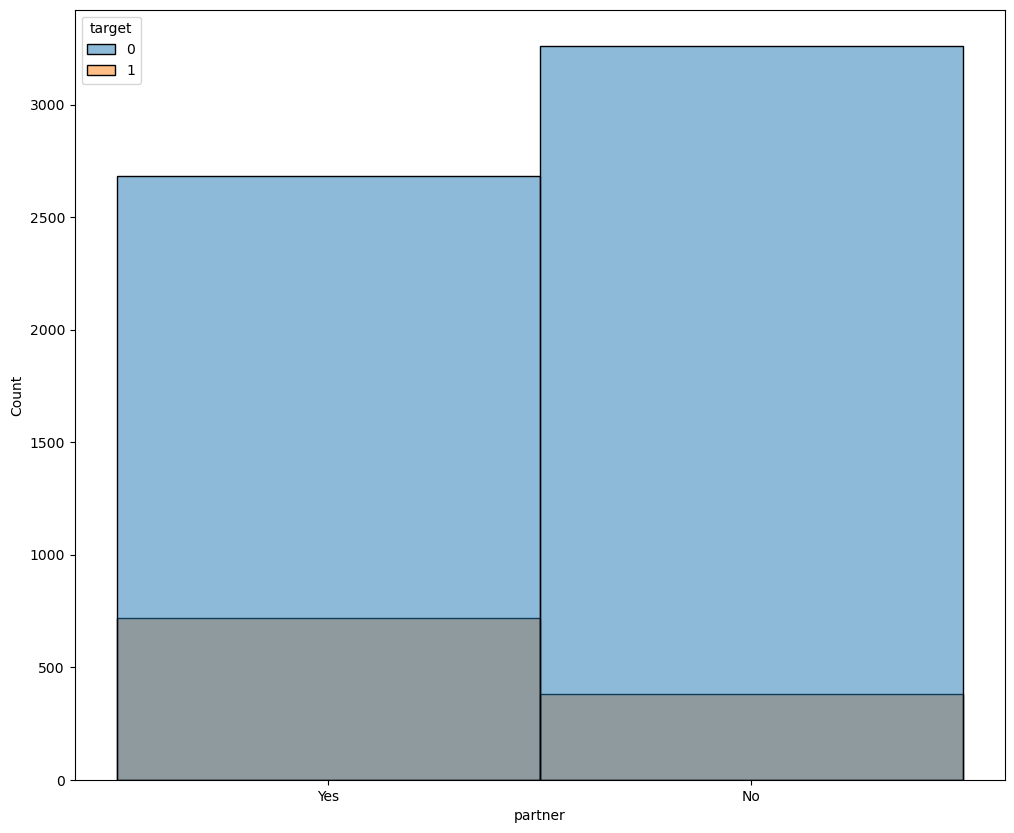


Корреляция Phik: 0.23
-----------------------------------------------------------------------------------------------



In [50]:
violent_plot(df, 'partner','target')

Если у пользователя есть супруга/супруга, то такие пользователи чаще уходят

Посмотрим как общие расходы абонента влияют на целевую переменную

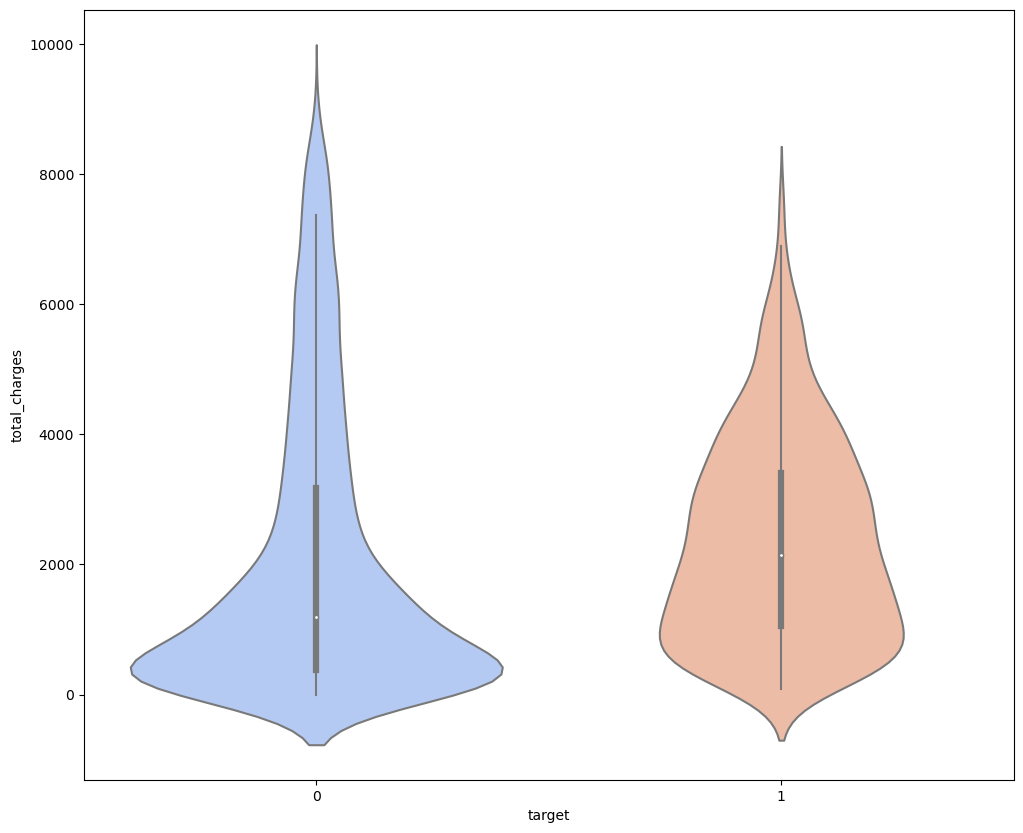


Корреляция Phik: 0.3
-----------------------------------------------------------------------------------------------



In [51]:
violent_plot(df, 'total_charges','target')

У пользователей которые остались у данного оператор связи меньше расход денег, может имеет смысл дать рекомендации пользователям которые ушли, что они могут более экономно пользоваться услугами и сделать программу акцию "возвращения"

Посмотрим как тип оплаты платеже влияет на то, уйдет ли человек от оператора связи или нет

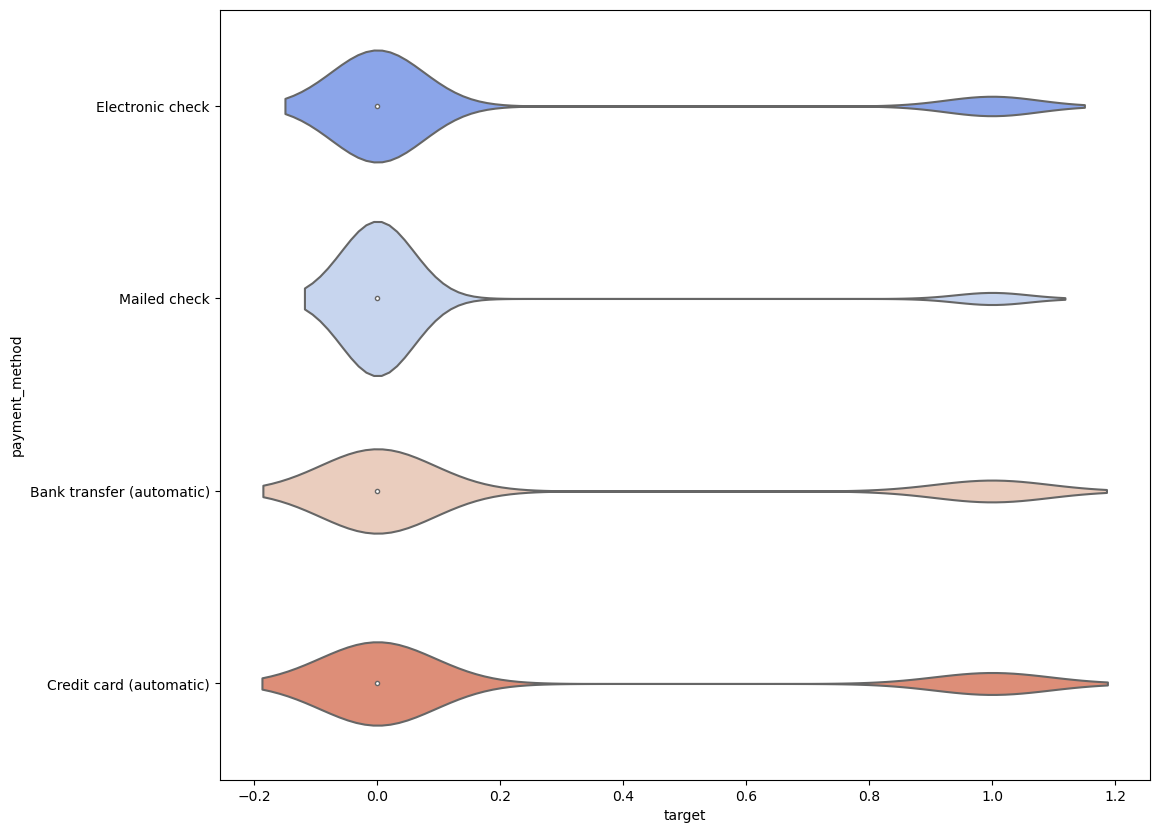

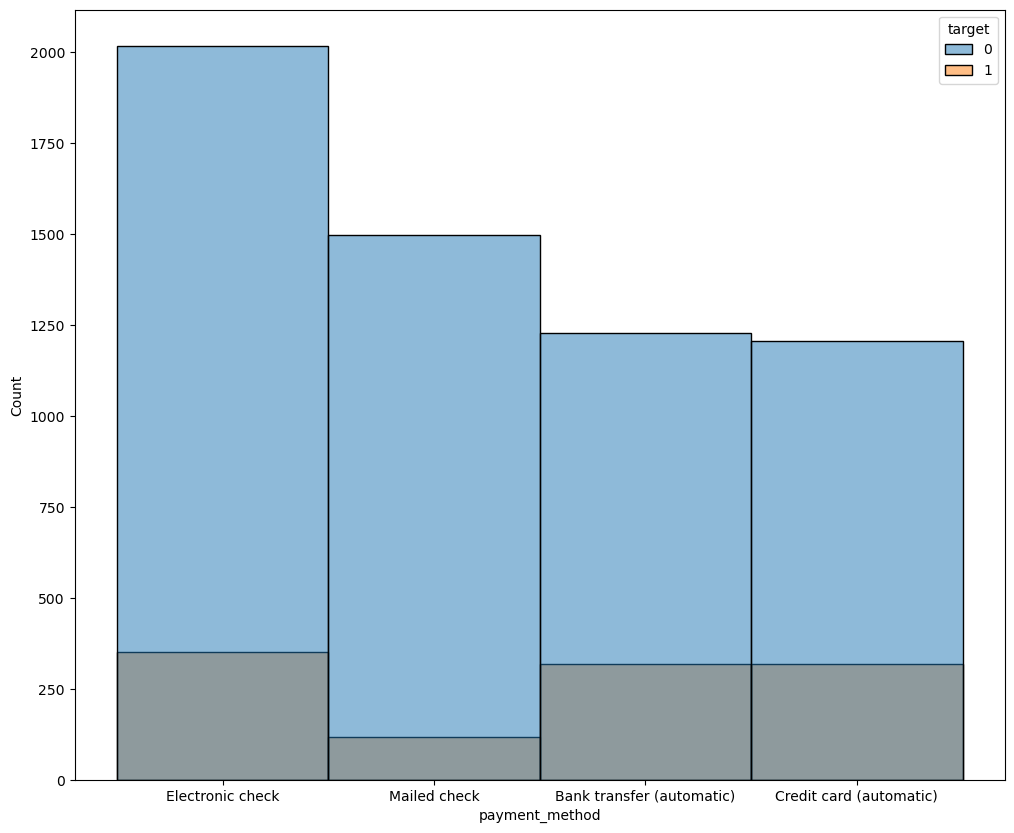


Корреляция Phik: 0.21
-----------------------------------------------------------------------------------------------



In [52]:
violent_plot(df, 'payment_method','target')

Тут более менее все одинаково, но можно заметить что люди которые оплачивают с помощью электронного чека на почту более редко отказываются от услуг оператора связи

### Выводы по EDA
* С каждым годом все меньше людей начинают пользоваться услугами оператора связи, так же c каждым годом все больше людей расторгают договоры с оператором
* Создали новый признак *count_services*, который показывает сколько интернет услуг было подключено у пользователя 
* Так же добавили признак *internet_connected*, который показывает подключены ли услуги интернета у пользователя

## Подготовка данных

Разделим данные на выборки

In [53]:
features = df.drop('target', axis=1)
target = df['target']

Разделим данные в соотношение размера тренировочной выборки к тестовой - 3 к 1

In [54]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target,
    test_size=0.25,
    stratify=target,
    random_state=RANDOM_STATE)

Проверим размеры полученных выборок

In [55]:
print('features_train:',features_train.shape[0])
print('target_train:',target_train.shape[0])
print()
print('features_test:',features_test.shape[0])
print('target_test:',target_test.shape[0])

features_train: 5282
target_train: 5282

features_test: 1761
target_test: 1761


Проверим баланс классов

In [56]:
print('Тренировочная выборка:')
display(target_train.value_counts(normalize=True))

print('Тестовая выборка:')
display(target_train.value_counts(normalize=True))

Тренировочная выборка:


0    0.84362
1    0.15638
Name: target, dtype: float64

Тестовая выборка:


0    0.84362
1    0.15638
Name: target, dtype: float64

Для кодирования и масштабирования, попробуем *make_column_transformer* 

In [57]:
num = ['monthly_charges', 'total_charges', 'end_begin_diff']
categorical = ['payment_method',
               'senior_citizen', 'partner',
               'multiple_lines', 'count_services']
col_transformer_for_tree = make_column_transformer( 
    ( 
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        categorical
    ), 
    ( 
        StandardScaler(), 
        num
    ), 
    verbose_feature_names_out=False 
)

col_transformer_lin = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        categorical
    ),
    (
        StandardScaler(),
        num
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

## Обучение моделей машинного обучения

Обучим 3 модели машинного обучения:
* LogisticRegression
* Ridge
* DecisionTreeClassifier
* RandomForestClassifier
* CatBoostClassifier

### LogisticRegression

Создадим переменную **params** в которой будут гиперпараметры среди которых мы будем искать лучшие

In [58]:
params = {'logisticregression__C': np.linspace(0.01, 1000, 100),
          'logisticregression__penalty': ['l2'],
          'logisticregression__solver': ['liblinear', 'newton-cg', 'sag', 'saga'],
          'logisticregression__class_weight': ['balanced'],
         }

С помощью **GridSearchCV** найдем лучшие параметры которые мы задали в **params**, выведем лучшую оценку ROC-AUC

In [59]:
model_LR = LogisticRegression(random_state=RANDOM_STATE)
pipeline_LR = make_pipeline(col_transformer_lin, model_LR)

LR_gscv = GridSearchCV(pipeline_LR, params, cv=3, scoring='roc_auc')
LR_gscv.fit(features_train, target_train)

print('Лучшее значение метрики:', round(LR_gscv.best_score_, 3),'\n')
print('Подобранные гиперпараметры модели')
LR_gscv.best_params_

Лучшее значение метрики: 0.722 

Подобранные гиперпараметры модели


{'logisticregression__C': 50.514545454545456,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'sag'}

### Ridge

Создадим переменную **params** в которой будут гиперпараметры среди которых мы будем искать лучшие

In [60]:
params = {'ridge__alpha': np.linspace(0, 1, 100)}

С помощью **GridSearchCV** найдем лучшие параметры которые мы задали в **params**, выведем лучшую оценку ROC-AUC

In [61]:
model_RIDGE = Ridge(random_state=RANDOM_STATE)
pipeline_RIDGE = make_pipeline(col_transformer_lin, model_RIDGE)

RIDGE_gscv = GridSearchCV(pipeline_RIDGE, params, cv=3, scoring='roc_auc')
RIDGE_gscv.fit(features_train, target_train)

print('Лучшее значение метрики:', round(RIDGE_gscv.best_score_, 3),'\n')
print('Подобранные гиперпараметры модели')
RIDGE_gscv.best_params_

Лучшее значение метрики: 0.719 

Подобранные гиперпараметры модели


{'ridge__alpha': 0.98989898989899}

### DecisionTreeClassifier

Создадим переменную **params** в которой будут гиперпараметры среди которых мы будем искать лучшие

In [62]:
params = {'decisiontreeclassifier__max_depth' : [1, 5,10, 25, 50],
           'decisiontreeclassifier__min_samples_split' : [2,4,6],
           'decisiontreeclassifier__min_samples_leaf' : [1,2,3],
           'decisiontreeclassifier__class_weight' : ['balanced']
         }

С помощью **GridSearchCV** найдем лучшие параметры которые мы задали в **params**, выведем лучшую оценку ROC-AUC

In [63]:
model_DTC = DecisionTreeClassifier(random_state=RANDOM_STATE)
pipeline_DTC = make_pipeline(col_transformer_for_tree, model_DTC)

DTC_gscv = GridSearchCV(pipeline_DTC, params, cv=3, scoring='roc_auc')
DTC_gscv.fit(features_train, target_train)

print('Лучшее значение метрики:', round(DTC_gscv.best_score_, 3),'\n')
print('Подобранные гиперпараметры модели')
DTC_gscv.best_params_

Лучшее значение метрики: 0.751 

Подобранные гиперпараметры модели


{'decisiontreeclassifier__class_weight': 'balanced',
 'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2}

### RandomForestClassifier

Создадим переменную **params** в которой будут гиперпараметры среди которых мы будем искать лучшие

In [64]:
params = [{ 'randomforestclassifier__n_estimators' : [50,100,200,400],
           'randomforestclassifier__max_depth' : [10, 25, 50],
           'randomforestclassifier__min_samples_split' : [2,4,6],
           'randomforestclassifier__min_samples_leaf' : [1,2,3],
           'randomforestclassifier__class_weight' : ['balanced']
         }]

С помощью **GridSearchCV** найдем лучшие параметры которые мы задали в **params**, выведем лучшую оценку ROC-AUC

In [65]:
model_RFC = RandomForestClassifier(random_state=RANDOM_STATE)
pipeline_RFC = make_pipeline(col_transformer_for_tree, model_RFC)

RFC_gscv = GridSearchCV(pipeline_RFC, params,cv=3, scoring='roc_auc')
RFC_gscv.fit(features_train, target_train)

print('Лучшее значение метрики:', round(RFC_gscv.best_score_, 3),'\n')
print('Подобранные гиперпараметры модели')
RFC_gscv.best_params_

Лучшее значение метрики: 0.792 

Подобранные гиперпараметры модели


{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__min_samples_leaf': 3,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 200}

### CatBoostClassifier

Создадим переменную **params** в которой будут гиперпараметры среди которых мы будем искать лучшие

In [66]:
params = [{'catboostclassifier__verbose': [False],
          'catboostclassifier__random_state': [RANDOM_STATE],
          'catboostclassifier__learning_rate': [0.01, 0.25, 0.5, 0.75, 1],
          'catboostclassifier__depth': np.arange(1, 10),
          'catboostclassifier__subsample': np.arange(0.05, 1, 0.31)
         }]

С помощью **GridSearchCV** найдем лучшие параметры которые мы задали в **params**, выведем лучшую оценку ROC-AUC

In [67]:
model_CBC = CatBoostClassifier(random_state=RANDOM_STATE)
pipeline_CBC = make_pipeline(col_transformer_for_tree, model_CBC)

CBC_gscv = GridSearchCV(pipeline_CBC, params,cv=3, scoring='roc_auc')
CBC_gscv.fit(features_train, target_train)

print('Лучшее значение метрики:', round(CBC_gscv.best_score_, 3),'\n')
print('Подобранные гиперпараметры модели')
CBC_gscv.best_params_

Лучшее значение метрики: 0.907 

Подобранные гиперпараметры модели


{'catboostclassifier__depth': 2,
 'catboostclassifier__learning_rate': 0.25,
 'catboostclassifier__random_state': 27112023,
 'catboostclassifier__subsample': 0.98,
 'catboostclassifier__verbose': False}

## Выбор лучшей модели

Лучше всех показала себя модель CatBoostClassifier, с оценкой 0.907, что удовлетворяет условию заказчика ROC-AUC >= 0.85. протестируем нашу модель на тестовой выборке

Инициализируем модель с лучшими параметрами, которые мы нашли выше

In [68]:
model = CBC_gscv.best_estimator_

features_test = pd.DataFrame(
    col_transformer_for_tree.transform(features_test),
    columns=col_transformer_for_tree.get_feature_names_out()
)

Посмотрим на ROC-AUC модели на тестовой выборке

In [69]:
roc_auc_score(target_test, model.predict_proba(features_test)[:,1])

0.9424874587054937

ROC-AUC на тестовой выборке 0.942, что еще лучше, чем результаты на выборе модели

Посмотрим оценку модели по метрике accuracy

In [70]:
accuracy_score(target_test, model.predict(features_test))

0.9494605337876206

Посмотрим ROC-кривую

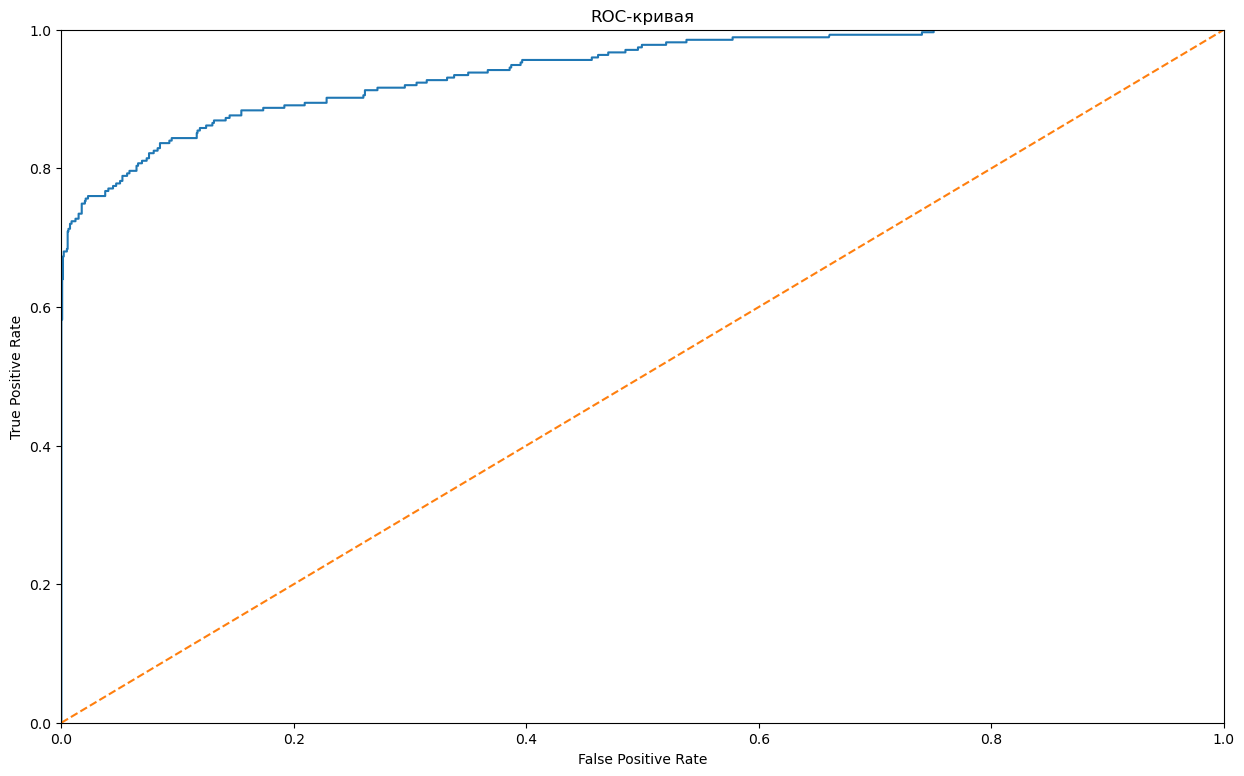

In [71]:
predicted_probalities = model.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, predicted_probalities)

plt.figure(figsize=(15, 9))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

Как мы видим график нашей модели имеет довольно большую площадь под собой что говорит нам о том, что модель правильно идентифицирует большинство ушеднших пользователей

Посмотрим матрицу ошибок

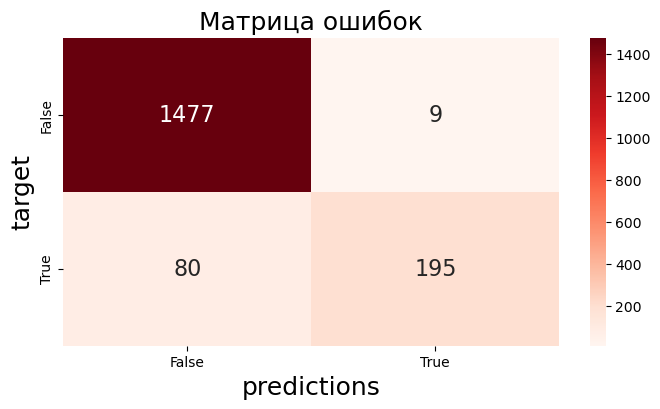

In [72]:
cm_cbc = confusion_matrix(target_test, model.predict(features_test))
cm_cbc_data = pd.DataFrame(cm_cbc,
                           index=['False', 'True'],
                           columns=['False', 'True'])

plt.figure(figsize=(8, 4))
sns.heatmap(cm_cbc, xticklabels=cm_cbc_data.columns, yticklabels=cm_cbc_data.index, annot=True, fmt='g', cmap="Reds", annot_kws={"size": 16})
plt.title("Матрица ошибок", size=18)
plt.xlabel('predictions', size=18)
plt.ylabel('target', size=18);

Как мы видим больше всего значений находиться в TN, что значит что модель определила 1458 людей как тех кто не ушел от оператора связи и это действительно так. Так же модель чаще ошибаеться на людях которые ушли FN-TN, в среднем 1 раз за 3 ушедших пользователя 

In [73]:
pivot_table = pd.DataFrame({'name': model[:-1].get_feature_names_out(),
    'score': model.named_steps['catboostclassifier'].get_feature_importance()})
pivot_table.sort_values(by='score', ascending=False)

,name,score
7,end_begin_diff,71.432521
6,total_charges,10.313269
5,monthly_charges,9.640614
4,count_services,2.783276
0,payment_method,1.987192
2,partner,1.850293
3,multiple_lines,1.695283
1,senior_citizen,0.297551


Самыми важными признаками стали:
* end_begin_diff - количество дней которые пользователь пользуеться услугами оператора связи
* total_charges - общие расходы абонента
* monthly_charges - расходы за месяц

### Вывод:
Мы разработали модель, которая удовлетворяет требованию заказчика ROC-AUC >= 0.85 \
Оценки нашей модели:
* ROC-AUC - 0.942
* accuracy - 0.949

Модель намного лучше определяет людей кто не ушел от оператора связи, а среди тех кто ушел модель совершает ошибку 1 раз из 3.\
Так же мы выяснили что у бизнеса есть проблемы, так как c каждым годом все меньше людей начинают пользоваться услугами оператора связи, так же c каждым годом все больше людей расторгают договоры с оператором.